In [1]:
import nltk, string, openpyxl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

In [24]:
# Read in data, extract the old and new blurbs, as well as if they match exactly
data = pd.read_excel('../data_temps.ods', engine = 'odf').dropna().to_numpy()
old_blurbs = data[:, 0].tolist()
new_blurbs = data[:, 1].tolist()

print(f'We have {len(old_blurbs)} blurbs to analyse')

We have 198 blurbs to analyse


In [3]:
# Also get a list of the temp decisions
significance_map = {'No': False, 'Yes': True}
significant = [*map(significance_map.get, data[:, 2].tolist())] 


In [4]:
# Define a function to use the Porter stemmer to stem a list of tokens
def stem_tokens(tokens):
    """Stems a list of tokens using a modified version of the Porter stemming algorithm
    provided by the nltk package.
    
    Parameters
    ----------
    tokens: list
        a list of tokens
        
    Returns
    stemmed_tokens: list
        a list of stemmed tokens
    """
    # Load in Martin Porter's stemming algorithm
    stemmer = nltk.stem.porter.PorterStemmer()
    
    # Stem each token in the input list
    stemmed_tokens = [stemmer.stem(item) for item in tokens]
    return stemmed_tokens

# Define a function to normalise a text document given as a string
def normalise(text):
    """Normalises text data by removing punctation, setting everything to lower case and tokenising.
    
    Punctation list provided by the string module.
    
    Parameters
    ----------
    text: string
        a text document
        
    Returns
    ---------
    token: list
        a list of tokens for the normalised text
    """
    # Define a map which removes punctation
    remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

    # First we remove punctuation
    punc = text.translate(remove_punctuation_map)
    
    # Then set everything to lower case
    lower = punc.lower()
    
    # And finally, tokenise
    token = nltk.word_tokenize(lower)
    return token

def cosine_sim(doc_1, doc_2):
    """Calculate the cosine similarity between two text documents.
    
    Parameters
    ----------
    doc_1: string
        the first document
    
    doc_2: string
        the second document
        
    Returns
    ---------
    cos_sim: float between 0 and 1
        the cosine similarity between document 1 and 2
    """
    # Define a vectoriser using the term frequency-inverse document frequency (TF-IDF) measure
    # (The more frequent a word appears, the less important it is)
    vectoriser = TfidfVectorizer(tokenizer = normalise, stop_words = 'english')
    
    # Learn the vocabulary of the two documents, and transform to vectors using TF-IDF
    tf_idf = vectoriser.fit_transform([doc_1, doc_2])
    
    # Calculate the pairwise similarity matrix
    pairwise_similarity = ( tf_idf * tf_idf.T ).toarray()
    
    # Return the similarity
    return pairwise_similarity[0, 1]

In [5]:
similarities = np.zeros(len(old_blurbs))
for i in tqdm(range(len(old_blurbs))):
    similarities[i] = cosine_sim(old_blurbs[i], new_blurbs[i])

  0%|          | 0/198 [00:00<?, ?it/s]

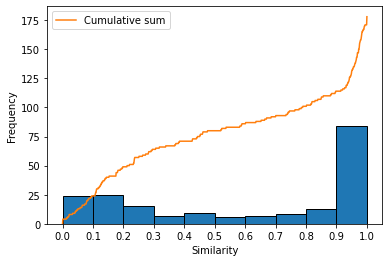

In [6]:
# Looks like the majority of the blurbs are very similar (0.9+)
granularity = 1000
num_less = np.zeros(granularity)
for index, num in enumerate(np.linspace(0, 1, granularity)):
    num_less[index] = sum(similarities < num)
    
plt.hist(similarities, ec = 'black', density = False)
plt.plot(np.linspace(0, 1, granularity), num_less, label = 'Cumulative sum')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
# Looks like many of the documents are actually exactly the same.
# Floating point errors mean that values that should be 1 often erroneously end up as 0.9999999 etc
print(f'It turns out that {sum(similarities > 0.999)} out of {len(old_blurbs)} blurbs are exactly equal.')

It turns out that 27 out of 198 blurbs are exactly equal.


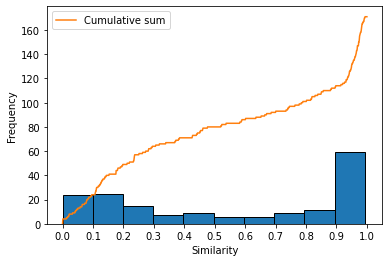

In [8]:
granularity = 1000
num_less = np.zeros(granularity)
for index, num in enumerate(np.linspace(0, 1, granularity)):
    num_less[index] = sum(similarities[similarities < 0.999] < num)
    
plt.hist(similarities[similarities < 0.999], ec = 'black', density = False)
plt.plot(np.linspace(0, 1, granularity), num_less, label = 'Cumulative sum')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

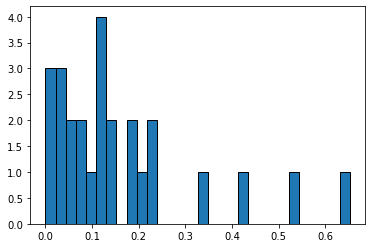

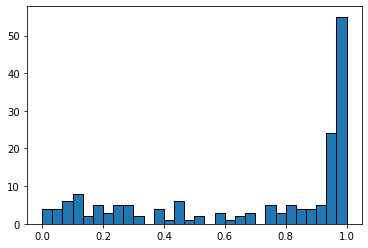

[0.0, 0.11836768991681565, 0.16285044878363902, 0.6525767901624497]
[0.0, 0.8894229850128332, 0.6841736647984109, 1.0000000000000007]


In [9]:
# Lets see what the similarity scores are for each temp decision
true_similarities = similarities[np.where(significant)]
false_similarities = similarities[np.where([not x for x in significant])]

plt.hist(true_similarities, ec = 'black', bins = 30)
plt.show()

plt.hist(false_similarities, ec = 'black', bins = 30)
plt.show()

def summary(similarities):
    """Output a table of summary statistics"""
    return [np.min(similarities), np.median(similarities), np. mean(similarities), np.max(similarities)]

print(summary(true_similarities))
print(summary(false_similarities))

# This suggests that choosing a similarity score of around 0.8 would remove the vast majority of the
# insubstantial changes but leave all of the substantial ones

In [10]:
def compare_blurbs(index, similarity = False, temp_decision = False):
    """Print out the two blurbs, as well as their similarity score if requested.
    
    Parameters
    ----------
    index: integer greater than or euqal to 0
        the index of which to query
    
    similarty: boolean
        whether or not the similarity score should be printed
    
    similarty: boolean
        whether or not the temp decision should be printed
        
    Yields
    --------
    The data index, the two blurbs, and optionally, the similarity score are printed to the console
    """
    print('----------------------------------------------------------------------'\
          '------------------------------------------------------')
    print(f'Index: {index} \n')
    if similarity:   
        print(f'Similarity: {round(cosine_sim(old_blurbs[index], new_blurbs[index]), 3)}\n')
    if temp_decision:
        print(f'Temp decision: {significant[index]}\n')
    print(old_blurbs[index], '\n')
    print(new_blurbs[index], '\n')

compare_blurbs(0, similarity = True, temp_decision = True)

----------------------------------------------------------------------------------------------------------------------------
Index: 0 

Similarity: 0.453

Temp decision: False

Established in Scotland in 1987, Orion Group has achieved consistent growth over the ensuing 31 years and is now an international leader in the provision of personnel to a number of industry sectors.Today Orion Group manages the placement of thousands of contractors and permanent personnel every year via their worldwide network of offices throughout Europe, the Americas, the Middle East, Asia Pacific and Africa.Orion provide specialist recruitment services across a range of sectors including; Life Sciences, New Energies, Oil and Gas, Construction & Infrastructure, Mining, Nuclear, Power & Utilities, Marine, Rail, IT, Finance, Office. Orion has the market intelligence and the experience necessary to take a holistic approach to project delivery – managing manpower provision from start to finish. 

Established in S

In [11]:
# Lets have a look at if those blurbs under this arbitrary threshold look to be different enough
threshold = 0.8

for index, similarity in enumerate(similarities):
    if similarity < threshold:
        compare_blurbs(index, similarity = True, temp_decision = True)
        
# Scrolling through these the theshold of 0.8 seems to be doing a good job of removing all insubstantial changes.
# The threshold could probably be even more stringent, but here at least we are catching substantial changes, even if
# it wouldnt make a significant different to how a company is perceived     

----------------------------------------------------------------------------------------------------------------------------
Index: 0 

Similarity: 0.453

Temp decision: False

Established in Scotland in 1987, Orion Group has achieved consistent growth over the ensuing 31 years and is now an international leader in the provision of personnel to a number of industry sectors.Today Orion Group manages the placement of thousands of contractors and permanent personnel every year via their worldwide network of offices throughout Europe, the Americas, the Middle East, Asia Pacific and Africa.Orion provide specialist recruitment services across a range of sectors including; Life Sciences, New Energies, Oil and Gas, Construction & Infrastructure, Mining, Nuclear, Power & Utilities, Marine, Rail, IT, Finance, Office. Orion has the market intelligence and the experience necessary to take a holistic approach to project delivery – managing manpower provision from start to finish. 

Established in S

In [12]:
# Lets see those between 0.8 and 0.9
upper_threshold = 0.9
lower_threshold = 0.8

for index, similarity in enumerate(similarities):
    if similarity < upper_threshold and similarity > lower_threshold:
        compare_blurbs(index, similarity = True, temp_decision = True)
        
# Scrolling through I can't see any here that I would think make a significant different to how a company is perceived

----------------------------------------------------------------------------------------------------------------------------
Index: 2 

Similarity: 0.829

Temp decision: False

Acer Ventures Plc is a IT consultancy and distributor of the Stratos Market Analyst Product Suit.Acer Ventures Plc is headquartered in London, England and registered in England and Wales as a Plc company with registration number 06851816.Stratos Market Analyst is powerful enough for the world’s top traders and yet simple enough for someone looking to start trading to be able to learn the program in just a few short days. Stratos Market Analyst has been developed to assist individual traders, professional traders, hedge funds, investors, brokers and money managers to achieve profitability from trading equities.We use a team of developers and programmers that have proven themselves to be successful traders and software engineers in their respective fields in the development of our software. The R&D team spend thei

In [22]:
def similarity_subset(input_data_path, output_data_path, threshold = 0.8, return_ = False):
    """Function to load data consisting of two columns, the first containing old company blurbs
    the second containing new blurbs, work out their similarity and return a new data file consisting 
    of only those blurbs that are more different than some user-specified threshold.
    
    Parameters
    ----------
    input_data_path: string
        the path to the data file, the data must be an excel table
    
    output_data_path: string
        the path where you want save the new data file e.g. './new_data.ods'
    
    threshold: float betweeon 0 and 1
        the cut off point at which we filter out a blurb for not being similar enough,
        the higher the threshold, the more similar we allow blurbs to be
        
    return_: boolean
        decides whether or not the new dataset is returned
    """
    # Read in data, drop the empty rows
    data = pd.read_excel(input_data_path, engine = 'odf').dropna().to_numpy()
    
    N = data.shape[0]
    print(f'Number of blurbs: {N}')
    
    # Remove those rows that are identical
    data = data[data[:, 0] != data[:, 1]]
    print(f'Removed {N - data.shape[0]} identical blurbs...')
    
    # Extract remaining blurbs
    old_blurbs = data[:, 0].tolist()
    new_blurbs = data[:, 1].tolist()
    
    # Compute similarities and remove the rows that are below the threshold
    print('Computing similarities of remaining blurbs...')
    similarities = np.zeros(len(old_blurbs))
    for i in tqdm(range(len(old_blurbs))):
        similarities[i] = cosine_sim(old_blurbs[i], new_blurbs[i])
    
    M = sum(similarities < threshold)
    print(f'Remaining number of blurbs: {M}. Total reduction of {round((N - M)/N * 100, 2)}%!')
    
    print(f'Saving file to the path {output_data_path}')
    # Find those blurbs where the similarity is less than our threshold, 
    # and output them to a new excel file
    threshed_indexes = np.where(similarities < threshold)
    new_data = pd.DataFrame( data[threshed_indexes] )
    new_data.to_excel(output_data_path,
                      index = False,
                      header = ['Old - Own blurb from the bridge',
                                'New - Own blurb you would copy paste onto the bridge',
                                'Does the change affect your fundamental understanding of the company?'])
    
    # If we wanted to return the new dataset, return it
    if return_:
        return new_data

    

In [23]:
similarity_subset('../data_temps.ods', '../new_data_temps.ods', 0.8)

Number of blurbs: 198
Removed 19 identical blurbs...
Computing similarities of remaining blurbs...


  0%|          | 0/179 [00:00<?, ?it/s]

Remaining number of blurbs: 101. Total reduction of 48.99%!
Saving file to the path ../new_data_temps.ods
